In [58]:
import os, random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [59]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [60]:
class SnakeEnv:
    def __init__(self, width=10, height=10, block_size=20, vision = "full"):
        pygame.init()
        self.width, self.height, self.block = width, height, block_size
        self.vision = vision  # "full" or "limited"
        self.display = pygame.Surface((self.width * self.block,
                                       self.height * self.block))
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self.direction = (1, 0)
        self.snake = [(self.width//2, self.height//2)]
        self._place_food()
        self.done, self.score = False, 0
        return self._get_obs()


    def _place_food(self):
        while True:
            self.food = (random.randrange(self.width),
                         random.randrange(self.height))
            if self.food not in self.snake:
                break

    def _get_obs(self):
        if self.vision == "limited":
            return self._get_limited_obs()
        return self._get_full_obs()


    def _get_full_obs(self):
        head_x, head_y = self.snake[0]
        dir_x, dir_y = self.direction
        food_x, food_y = self.food

        def danger_at(offset):
            dx, dy = offset
            new_x, new_y = head_x + dx, head_y + dy
            return int(
                new_x < 0 or new_x >= self.width or
                new_y < 0 or new_y >= self.height or
                (new_x, new_y) in self.snake
            )

        left  = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        danger = [
            danger_at(front),
            danger_at(right),
            danger_at(left)
        ]

        food_dx = int(np.sign(food_x - head_x))
        food_dy = int(np.sign(food_y - head_y))

        dir_features = [
            int(dir_x == 1), int(dir_x == -1),
            int(dir_y == 1), int(dir_y == -1)
        ]

        return np.array(danger + dir_features + [food_dx, food_dy], dtype=np.float32)
    
    def _get_limited_obs(self):
        head_x, head_y = self.snake[0]
        obs_size = 5
        radius = obs_size // 2

        obs = np.zeros((obs_size, obs_size), dtype=np.float32)

        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                x = head_x + dx
                y = head_y + dy

                if x < 0 or x >= self.width or y < 0 or y >= self.height:
                    val = -1.0  # wall
                elif (x, y) in self.snake:
                    val = -0.5  # snake body
                elif (x, y) == self.food:
                    val = 1.0   # food
                else:
                    val = 0.0   # empty

                obs[dy + radius][dx + radius] = val

        return obs.flatten()


    def step(self, action):
        dirs = [(-1,0),(0,1),(1,0),(0,-1)]
        new_dir = dirs[action]
        if (new_dir[0]==-self.direction[0] and
            new_dir[1]==-self.direction[1]):
            new_dir = self.direction
        self.direction = new_dir

        head = (self.snake[0][0]+new_dir[0],
                self.snake[0][1]+new_dir[1])
        if (not 0<=head[0]<self.width or
            not 0<=head[1]<self.height or
            head in self.snake):
            self.done = True
            return self._get_obs(), -10, True, {}

        self.snake.insert(0, head)
        if head == self.food:
            reward, self.score = 10, self.score+1
            self._place_food()
        else:
            reward = -0.1
            self.snake.pop()

        return self._get_obs(), reward, False, {}

    # Inside your SnakeEnv class, overwrite render() with:

    def render(self):
        """
        Return a (H_px, W_px, 3) uint8 image of the game:
         - snake in green, food in red, background black.
        """
        H_px = self.height * self.block
        W_px = self.width  * self.block
        frame = np.zeros((H_px, W_px, 3), dtype=np.uint8)

        # Draw snake
        for x, y in self.snake:
            y0, y1 = y*self.block, (y+1)*self.block
            x0, x1 = x*self.block, (x+1)*self.block
            frame[y0:y1, x0:x1] = np.array([0,255,0], dtype=np.uint8)

        # Draw food
        fx, fy = self.food
        y0, y1 = fy*self.block, (fy+1)*self.block
        x0, x1 = fx*self.block, (fx+1)*self.block
        frame[y0:y1, x0:x1] = np.array([255,0,0], dtype=np.uint8)

        return frame


In [61]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, path)

def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"Loaded checkpoint from {path}")
    else:
        print("No checkpoint found.")


In [62]:
def plot_rolling_average(rewards, window=50, label="RL", title="Rolling Average Reward"):
    rolling_avg = [np.mean(rewards[max(0, i - window):i+1]) for i in range(len(rewards))]
    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label="Reward")
    plt.plot(rolling_avg, label=f"Rolling Avg ({window})")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [63]:
def evaluate_policy(model, env, mode="dqn", n_episodes=10, max_steps=1000):
    model.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            for _ in range(max_steps):
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
                if mode == "dqn":
                    q_vals = model(state_tensor)
                    action = q_vals.argmax(dim=1).item()
                else:
                    probs, _ = model(state_tensor)
                    action = probs.argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
                if done:
                    break
            scores.append(total)
    model.train()
    return scores


In [64]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)


In [65]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [66]:
config_dqn = {
    "gamma": 0.99,
    "batch_size": 64,
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 5000,
    "target_update": 10,
    "num_episodes": 1000,
    "ckpt_path": "checkpoints/dqn_snake.pth",
    "total_env_steps": 300000
}

ppo_config = {
    "gamma":        0.99,
    "gae_lambda":   0.95,
    "clip_eps":     0.2,
    "lr":           2.5e-4,
    "epochs":       4,
    "batch_size":   64,
    "update_steps": 1024,
    "num_updates":  100,
    "total_env_steps": 300000
}


config_a2c = {
    "gamma": 0.99,
    "lr": 1e-4,
    "num_episodes": 1000,
    "total_env_steps": 300000
}




In [67]:
def select_action_dqn(state, eps, model):
    if random.random() < eps:
        return random.randrange(4)
    state_v = torch.from_numpy(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_vals = model(state_v)
    return q_vals.argmax(dim=1).item()

def optimize_dqn_step(memory, policy_net, target_net, optimizer, config):
    if len(memory) < config["batch_size"]:
        return
    transitions = memory.sample(config["batch_size"])
    batch = Transition(*zip(*transitions))

    states      = torch.from_numpy(np.array(batch.state)).float().to(device)
    actions     = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
    rewards     = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
    dones       = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q = rewards + config["gamma"] * next_q * (1 - dones)

    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
def train_dqn(env, policy_net, target_net, memory, optimizer, config, checkpoint_path):
    episode_rewards = []
    env_steps_list = []
    total_env_steps = 0
    steps_done = 0

    best_avg_reward = -float("inf")  # ✅ NEW: Track best model
    os.makedirs("checkpoints", exist_ok=True)  # ✅ NEW: Make save folder

    def get_epsilon(step):
        return config["eps_end"] + (config["eps_start"] - config["eps_end"]) * \
               np.exp(-1. * step / config["eps_decay"])

    while total_env_steps < config["total_env_steps"]:
        state = env.reset()
        total_reward = 0
        ep_steps = 0

        while True:
            eps = get_epsilon(steps_done)
            action = select_action_dqn(state, eps, policy_net)
            next_state, reward, done, _ = env.step(action)
            memory.push(state, action, reward, next_state, done)
            optimize_dqn_step(memory, policy_net, target_net, optimizer, config)

            state = next_state
            total_reward += reward
            steps_done += 1
            ep_steps += 1
            total_env_steps += 1

            if done or total_env_steps >= config["total_env_steps"]:
                break

        env_steps_list.append(total_env_steps)
        episode_rewards.append(total_reward)

        if len(episode_rewards) % config["target_update"] == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if len(episode_rewards) % 50 == 0:
            avg_50 = np.mean(episode_rewards[-50:])
            print(f"[DQN] Episode {len(episode_rewards)} | Avg(50): {avg_50:.2f}")

            # ✅ NEW: Save model if it's the best so far
            if avg_50 > best_avg_reward:
                best_avg_reward = avg_50
                save_checkpoint(policy_net, optimizer, checkpoint_path)
                print(f"[DQN] New best model saved! Avg(50): {avg_50:.2f}")

    return env_steps_list, episode_rewards


In [69]:
class RolloutBuffer:
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []

    def clear(self):
        self.__init__()

def compute_gae(rewards, values, dones, gamma, lam):
    advantages, gae = [], 0
    values = values + [0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return advantages


In [70]:
def collect_trajectory(env, model, buffer, steps, max_steps=1000):
    state = env.reset()
    actual_steps = 0

    for _ in range(steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, done, _ = env.step(action.item())

        buffer.states.append(state)
        buffer.actions.append(action.item())
        buffer.log_probs.append(dist.log_prob(action).item())
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.item())

        state = next_state
        actual_steps += 1
        if done:
            state = env.reset()

    return actual_steps


In [71]:
def ppo_update(model, optimizer, buffer, config):
    states = torch.tensor(buffer.states, dtype=torch.float32).to(device)
    actions = torch.tensor(buffer.actions).to(device)
    old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
    rewards, dones, values = buffer.rewards, buffer.dones, buffer.values

    advantages = compute_gae(rewards, values, dones, config["gamma"], config["gae_lambda"])
    returns = torch.tensor([a + v for a, v in zip(advantages, values)], dtype=torch.float32).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    for _ in range(config["epochs"]):
        for i in range(0, len(states), config["batch_size"]):
            s_batch = states[i:i+config["batch_size"]]
            a_batch = actions[i:i+config["batch_size"]]
            r_batch = returns[i:i+config["batch_size"]]
            adv_batch = advantages[i:i+config["batch_size"]]
            logp_old_batch = old_log_probs[i:i+config["batch_size"]]

            probs, values = model(s_batch)
            dist = torch.distributions.Categorical(probs)
            logp = dist.log_prob(a_batch)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logp - logp_old_batch)
            clipped = torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"]) * adv_batch
            loss_clip = -torch.min(ratio * adv_batch, clipped).mean()
            loss_value = F.mse_loss(values.squeeze(), r_batch)
            loss = loss_clip + 0.5 * loss_value - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [ ]:
def train_ppo(env, model, optimizer, config, checkpoint_path):
    buffer = RolloutBuffer()
    reward_history = []
    env_steps_list = []
    total_env_steps = 0

    best_avg_reward = -float("inf")  # ✅ Track best avg reward
    os.makedirs("checkpoints", exist_ok=True)  # ✅ Ensure save folder exists

    while total_env_steps < config["total_env_steps"]:
        steps_collected = collect_trajectory(env, model, buffer, config["update_steps"])
        ppo_update(model, optimizer, buffer, config)
        buffer.clear()

        total_env_steps += steps_collected
        eval_scores = evaluate_policy(model, env, mode="ppo", n_episodes=10)
        avg_reward = np.mean(eval_scores)
        reward_history.append(avg_reward)
        env_steps_list.append(total_env_steps)

        print(f"[PPO] Env Steps {total_env_steps} | Avg Eval Reward: {avg_reward:.2f}")

        # ✅ Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            save_checkpoint(model, optimizer, checkpoint_path)
            print(f"[PPO] New best model saved! Avg Eval Reward: {avg_reward:.2f}")

    return env_steps_list, reward_history


In [ ]:
def train_a2c(env, model, optimizer, config, checkpoint_path):
    rewards = []
    env_steps_list = []
    total_env_steps = 0
    gamma = config["gamma"]

    best_avg_reward = -float("inf")  # ✅ Track best average
    os.makedirs("checkpoints", exist_ok=True)  # ✅ Ensure folder exists

    while total_env_steps < config["total_env_steps"]:
        state = env.reset()
        total_reward = 0
        ep_steps = 0
        done = False

        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            probs, value = model(state_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done, _ = env.step(action.item())
            next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            _, next_value = model(next_state_tensor)

            target = reward + (1 - done) * gamma * next_value.item()
            advantage = target - value.item()

            policy_loss = -log_prob * advantage
            value_loss = F.mse_loss(value, torch.tensor([[target]], device=device))
            loss = policy_loss + value_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward
            ep_steps += 1
            total_env_steps += 1

            if total_env_steps >= config["total_env_steps"]:
                break

        env_steps_list.append(total_env_steps)
        rewards.append(total_reward)

        # ✅ Print and save model every 10 episodes
        if len(rewards) % 10 == 0:
            avg_reward = np.mean(rewards[-10:])
            print(f"[A2C] Episode {len(rewards)} | Avg(10): {avg_reward:.2f}")

            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                save_checkpoint(model, optimizer, checkpoint_path)
                print(f"[A2C] New best model saved! Avg(10): {avg_reward:.2f}")

    return env_steps_list, rewards


In [74]:
import os
import pickle

def save_results(path, steps, rewards):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump((steps, rewards), f)

def load_results(path):
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def smooth(y, window=20):
    return [np.mean(y[max(0, i - window):i+1]) for i in range(len(y))]


In [ ]:
from itertools import product

print("=== Grid Search: DQN (Full + Limited) ===")
dqn_results = {}
dqn_limited_results = {}

lr_vals = [1e-3, 1e-4]
gamma_vals = [0.99, 0.95]

for vision in ["full", "limited"]:
    is_limited = vision == "limited"
    result_dict = dqn_limited_results if is_limited else dqn_results

    for lr, gamma in product(lr_vals, gamma_vals):
        tag = f"lr: {lr:.0e} | gamma: {gamma}"
        file_tag = tag.replace(":", "").replace("|", "_").replace(" ", "")
        if is_limited:
            file_tag += "_limited"

        result_path = f"results/dqn_{file_tag}.pkl"

        cached = load_results(result_path)

        if cached:
            steps, rewards = cached
            print(f"Loaded: {tag} ({vision})")
        else:
            print(f"Training: {tag} ({vision})")
            env = SnakeEnv(vision=vision)
            state_dim = len(env.reset())
            action_dim = 4

            policy_net = DQN(state_dim, action_dim).to(device)
            target_net = DQN(state_dim, action_dim).to(device)
            target_net.load_state_dict(policy_net.state_dict())
            optimizer = optim.Adam(policy_net.parameters(), lr=lr)
            memory = ReplayMemory(capacity=10000)

            config = config_dqn.copy()
            config["gamma"] = gamma
            config["total_env_steps"] = 300_000

            checkpoint_path = f"checkpoints/dqn_{file_tag}.pth"
            steps, rewards = train_dqn(env, policy_net, target_net, memory, optimizer, config, checkpoint_path)

            save_results(result_path, steps, rewards)

        result_dict[tag] = (steps, rewards)


=== Grid Search: DQN (Full + Limited) ===
Loaded: lr: 1e-03 | gamma: 0.99 (full)
Loaded: lr: 1e-03 | gamma: 0.95 (full)
Loaded: lr: 1e-04 | gamma: 0.99 (full)
Loaded: lr: 1e-04 | gamma: 0.95 (full)
Loaded: lr: 1e-03 | gamma: 0.99 (limited)
Loaded: lr: 1e-03 | gamma: 0.95 (limited)


Loaded: lr: 1e-04 | gamma: 0.99 (limited)
Loaded: lr: 1e-04 | gamma: 0.95 (limited)


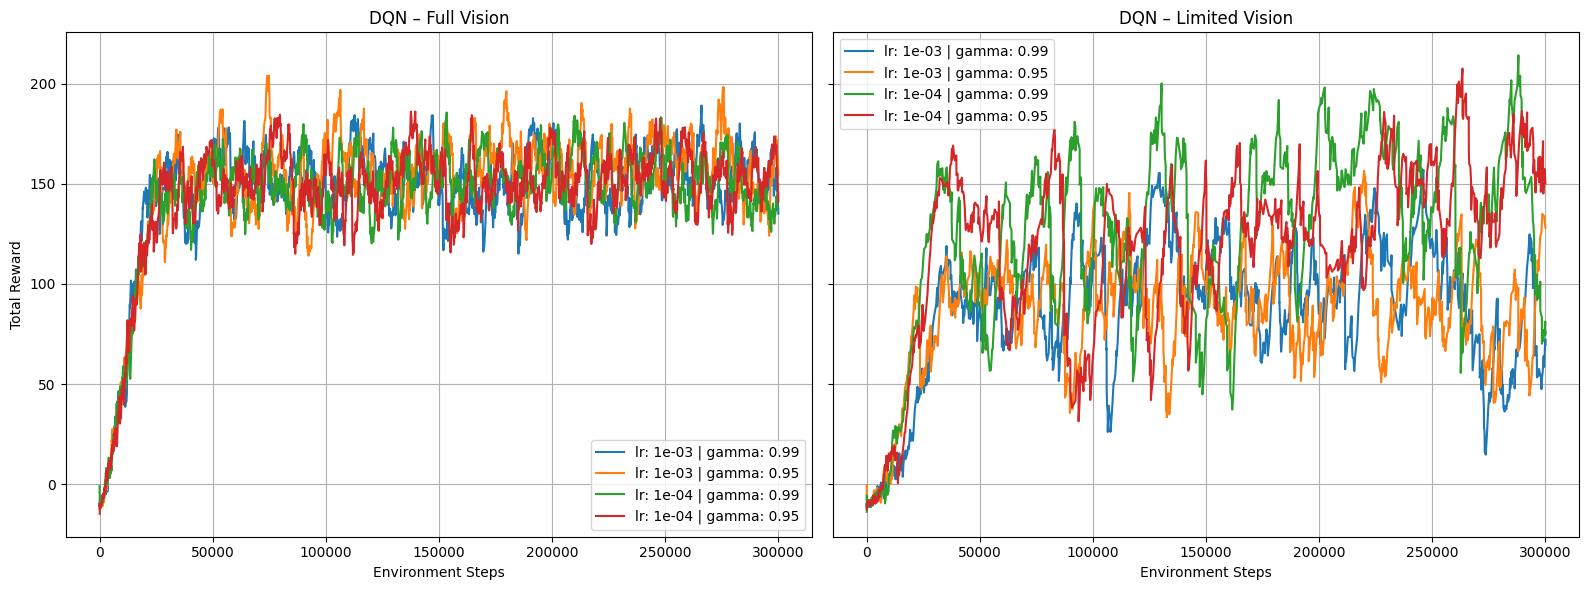

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Full vision
axs[0].set_title("DQN – Full Vision")
for tag, (steps, rewards) in dqn_results.items():
    axs[0].plot(steps, smooth(rewards), label=tag)
axs[0].set_xlabel("Environment Steps")
axs[0].set_ylabel("Total Reward")
axs[0].legend()
axs[0].grid(True)

# Limited vision
axs[1].set_title("DQN – Limited Vision")
for tag, (steps, rewards) in dqn_limited_results.items():
    axs[1].plot(steps, smooth(rewards), label=tag)
axs[1].set_xlabel("Environment Steps")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from itertools import product

print("=== Grid Search: PPO (Full + Limited) ===")
ppo_results = {}
ppo_limited_results = {}

lr_vals = [2.5e-4, 1e-4]
gamma_vals = [0.99, 0.95]

for vision in ["full", "limited"]:
    is_limited = vision == "limited"
    result_dict = ppo_limited_results if is_limited else ppo_results

    for lr, gamma in product(lr_vals, gamma_vals):
        tag = f"lr: {lr:.0e} | gamma: {gamma}"
        file_tag = tag.replace(":", "").replace("|", "_").replace(" ", "")
        if is_limited:
            file_tag += "_limited"

        result_path = f"results/ppo_{file_tag}.pkl"

        cached = load_results(result_path)

        if cached:
            steps, rewards = cached
            print(f"Loaded: {tag} ({vision})")
        else:
            print(f"Training: {tag} ({vision})")
            env = SnakeEnv(vision=vision)
            state_dim = len(env.reset())
            action_dim = 4

            model = ActorCritic(state_dim, action_dim).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)

            config = ppo_config.copy()
            config["lr"] = lr
            config["gamma"] = gamma
            config["total_env_steps"] = 300_000

            checkpoint_path = f"checkpoints/ppo_{file_tag}.pth"
            steps, rewards = train_dqn(env, policy_net, target_net, memory, optimizer, config, checkpoint_path)

            save_results(result_path, steps, rewards)

        result_dict[tag] = (steps, rewards)


=== Grid Search: PPO (Full + Limited) ===
Loaded: lr: 3e-04 | gamma: 0.99 (full)
Loaded: lr: 3e-04 | gamma: 0.95 (full)
Loaded: lr: 1e-04 | gamma: 0.99 (full)
Loaded: lr: 1e-04 | gamma: 0.95 (full)
Training: lr: 3e-04 | gamma: 0.99 (limited)
[PPO] Env Steps 1024 | Avg Eval Reward: -11.02
[PPO] Env Steps 2048 | Avg Eval Reward: -9.43
[PPO] Env Steps 3072 | Avg Eval Reward: -8.42
[PPO] Env Steps 4096 | Avg Eval Reward: -10.40
[PPO] Env Steps 5120 | Avg Eval Reward: -9.49
[PPO] Env Steps 6144 | Avg Eval Reward: -8.38
[PPO] Env Steps 7168 | Avg Eval Reward: -9.60
[PPO] Env Steps 8192 | Avg Eval Reward: -8.03
[PPO] Env Steps 9216 | Avg Eval Reward: -10.45
[PPO] Env Steps 10240 | Avg Eval Reward: -10.90
[PPO] Env Steps 11264 | Avg Eval Reward: -7.97
[PPO] Env Steps 12288 | Avg Eval Reward: -10.61
[PPO] Env Steps 13312 | Avg Eval Reward: -10.45
[PPO] Env Steps 14336 | Avg Eval Reward: -8.98
[PPO] Env Steps 15360 | Avg Eval Reward: -8.98
[PPO] Env Steps 16384 | Avg Eval Reward: -9.51
[PPO] Env

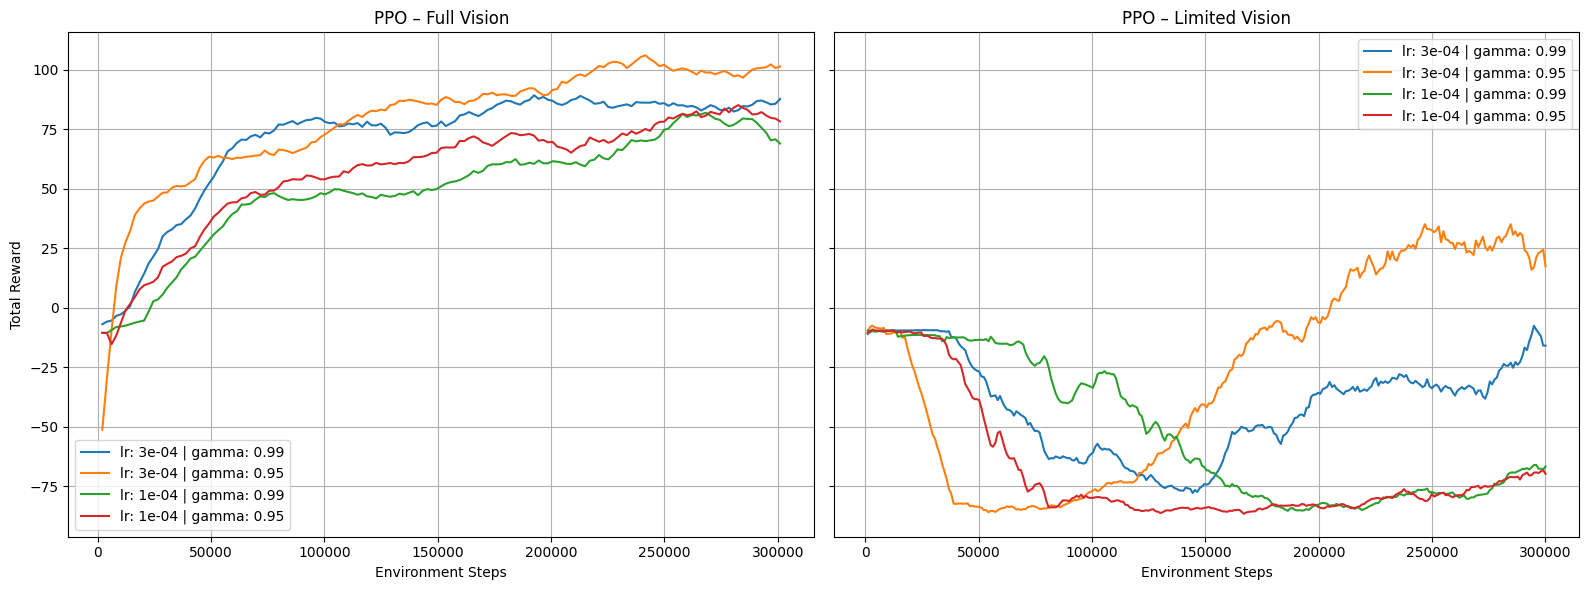

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Full vision
axs[0].set_title("PPO – Full Vision")
for tag, (steps, rewards) in ppo_results.items():
    axs[0].plot(steps, smooth(rewards), label=tag)
axs[0].set_xlabel("Environment Steps")
axs[0].set_ylabel("Total Reward")
axs[0].legend()
axs[0].grid(True)

# Limited vision
axs[1].set_title("PPO – Limited Vision")
for tag, (steps, rewards) in ppo_limited_results.items():
    axs[1].plot(steps, smooth(rewards), label=tag)
axs[1].set_xlabel("Environment Steps")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from itertools import product

print("=== Grid Search: A2C (Full + Limited) ===")
a2c_results = {}
a2c_limited_results = {}

lr_vals = [1e-3, 1e-4]
gamma_vals = [0.99, 0.95]

for vision in ["full", "limited"]:
    is_limited = vision == "limited"
    result_dict = a2c_limited_results if is_limited else a2c_results

    for lr, gamma in product(lr_vals, gamma_vals):
        tag = f"lr: {lr:.0e} | gamma: {gamma}"
        file_tag = tag.replace(":", "").replace("|", "_").replace(" ", "")
        if is_limited:
            file_tag += "_limited"

        result_path = f"results/a2c_{file_tag}.pkl"

        cached = load_results(result_path)

        if cached:
            steps, rewards = cached
            print(f"Loaded: {tag} ({vision})")
        else:
            print(f"Training: {tag} ({vision})")
            env = SnakeEnv(vision=vision)
            state_dim = len(env.reset())
            action_dim = 4

            model = ActorCritic(state_dim, action_dim).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)

            config = config_a2c.copy()
            config["lr"] = lr
            config["gamma"] = gamma
            config["total_env_steps"] = 300_000

            checkpoint_path = f"checkpoints/a2c_{file_tag}.pth"
            steps, rewards = train_dqn(env, policy_net, target_net, memory, optimizer, config, checkpoint_path)

            save_results(result_path, steps, rewards)

        result_dict[tag] = (steps, rewards)


=== Grid Search: A2C (Full + Limited) ===
Loaded: lr: 1e-03 | gamma: 0.99 (full)
Loaded: lr: 1e-03 | gamma: 0.95 (full)
Loaded: lr: 1e-04 | gamma: 0.99 (full)
Loaded: lr: 1e-04 | gamma: 0.95 (full)
Training: lr: 1e-03 | gamma: 0.99 (limited)
[A2C] Episode 10 | Avg(10): -9.87
[A2C] Episode 20 | Avg(10): -10.71
[A2C] Episode 30 | Avg(10): -9.73
[A2C] Episode 40 | Avg(10): -10.16
[A2C] Episode 50 | Avg(10): -10.18
[A2C] Episode 60 | Avg(10): -10.13
[A2C] Episode 70 | Avg(10): -8.57
[A2C] Episode 80 | Avg(10): -8.18
[A2C] Episode 90 | Avg(10): -9.90
[A2C] Episode 100 | Avg(10): -11.88
[A2C] Episode 110 | Avg(10): -10.95
[A2C] Episode 120 | Avg(10): -9.41
[A2C] Episode 130 | Avg(10): -7.47
[A2C] Episode 140 | Avg(10): -6.28
[A2C] Episode 150 | Avg(10): -9.61
[A2C] Episode 160 | Avg(10): -12.13
[A2C] Episode 170 | Avg(10): -10.62
[A2C] Episode 180 | Avg(10): -10.40
[A2C] Episode 190 | Avg(10): -10.15
[A2C] Episode 200 | Avg(10): -11.08
[A2C] Episode 210 | Avg(10): -11.20
[A2C] Episode 220 | 

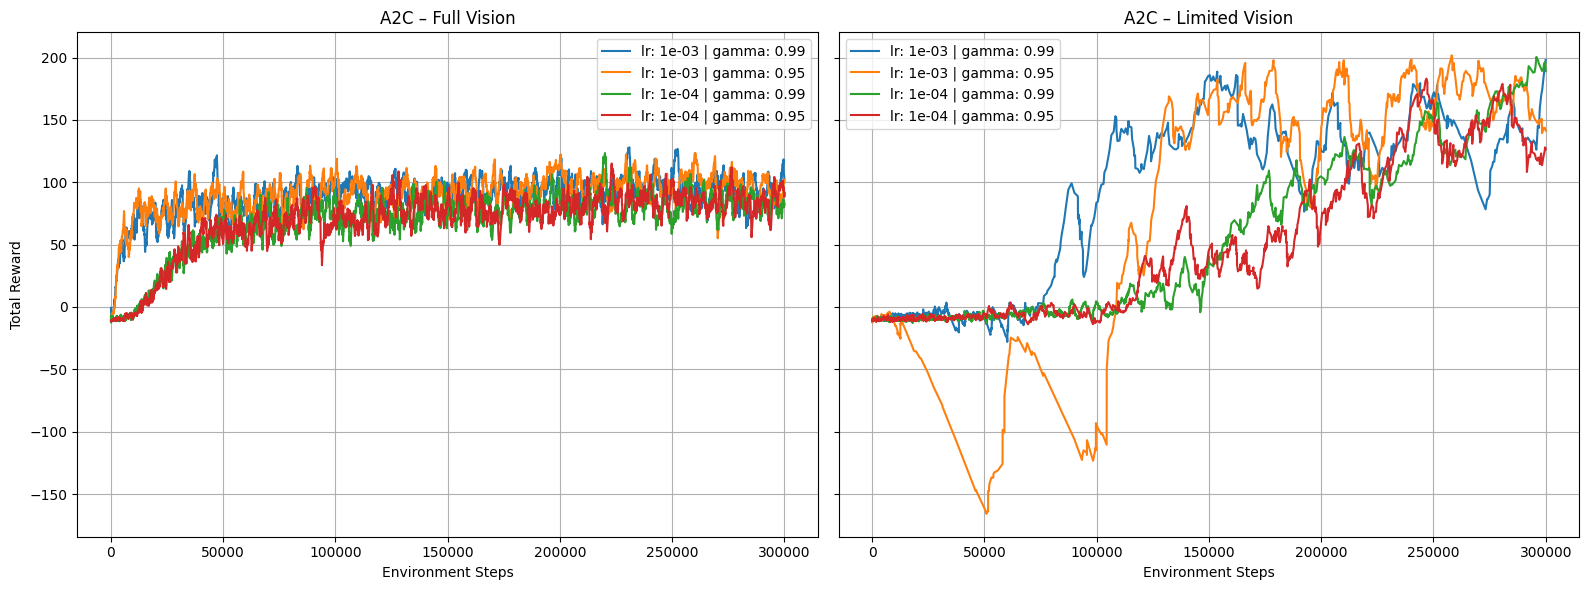

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Full vision
axs[0].set_title("A2C – Full Vision")
for tag, (steps, rewards) in a2c_results.items():
    axs[0].plot(steps, smooth(rewards), label=tag)
axs[0].set_xlabel("Environment Steps")
axs[0].set_ylabel("Total Reward")
axs[0].legend()
axs[0].grid(True)

# Limited vision
axs[1].set_title("A2C – Limited Vision")
for tag, (steps, rewards) in a2c_limited_results.items():
    axs[1].plot(steps, smooth(rewards), label=tag)
axs[1].set_xlabel("Environment Steps")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


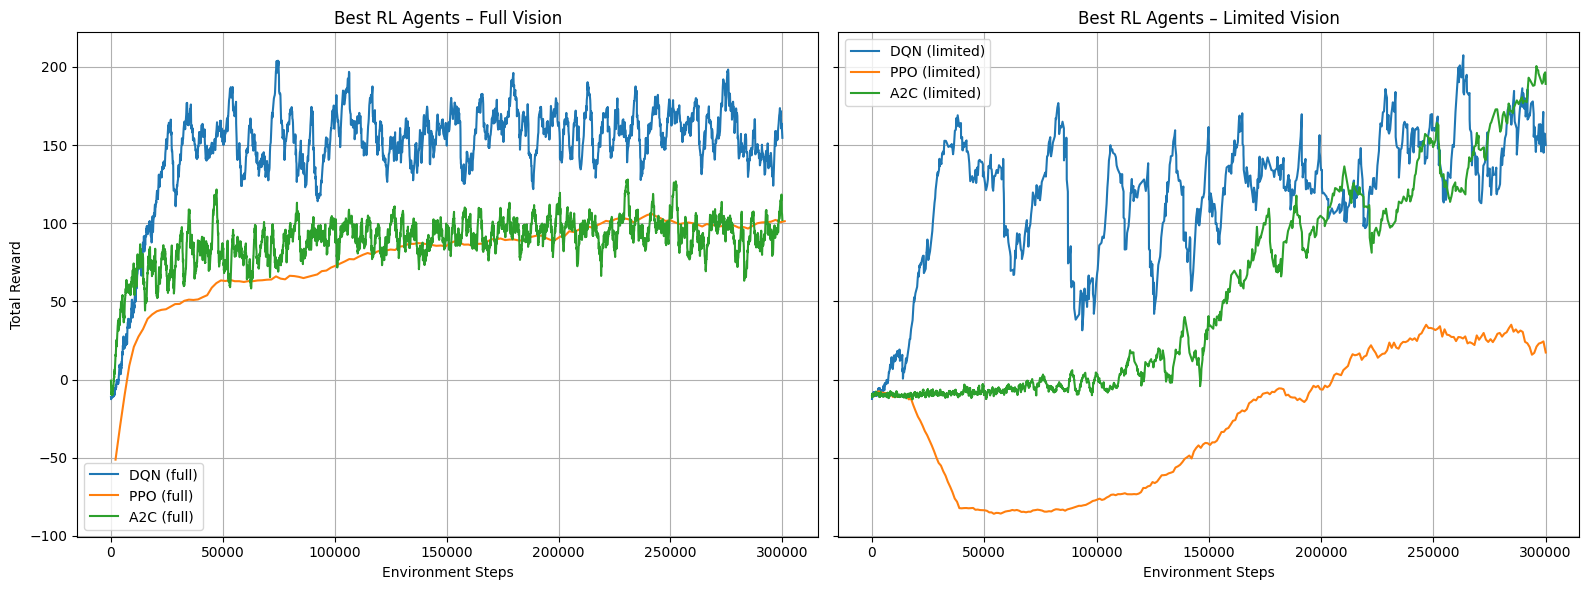

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# === Full Vision ===
axs[0].set_title("Best RL Agents – Full Vision")
best_dqn = dqn_results["lr: 1e-03 | gamma: 0.95"]
best_ppo = ppo_results["lr: 3e-04 | gamma: 0.95"]
best_a2c = a2c_results["lr: 1e-03 | gamma: 0.99"]

axs[0].plot(best_dqn[0], smooth(best_dqn[1]), label="DQN (full)")
axs[0].plot(best_ppo[0], smooth(best_ppo[1]), label="PPO (full)")
axs[0].plot(best_a2c[0], smooth(best_a2c[1]), label="A2C (full)")
axs[0].set_xlabel("Environment Steps")
axs[0].set_ylabel("Total Reward")
axs[0].legend()
axs[0].grid(True)

# === Limited Vision ===
axs[1].set_title("Best RL Agents – Limited Vision")
best_dqn_limited = dqn_limited_results["lr: 1e-04 | gamma: 0.95"]
best_ppo_limited = ppo_limited_results["lr: 3e-04 | gamma: 0.95"]
best_a2c_limited = a2c_limited_results["lr: 1e-04 | gamma: 0.99"]

axs[1].plot(best_dqn_limited[0], smooth(best_dqn_limited[1]), label="DQN (limited)")
axs[1].plot(best_ppo_limited[0], smooth(best_ppo_limited[1]), label="PPO (limited)")
axs[1].plot(best_a2c_limited[0], smooth(best_a2c_limited[1]), label="A2C (limited)")
axs[1].set_xlabel("Environment Steps")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
